<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Подготовка-и-разбивка-данных-для-обчуения-моделей" data-toc-modified-id="Подготовка-и-разбивка-данных-для-обчуения-моделей-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка и разбивка данных для обчуения моделей</a></span></li><li><span><a href="#Иследование-качества-модели-на-нешифрованных-данных" data-toc-modified-id="Иследование-качества-модели-на-нешифрованных-данных-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Иследование качества модели на нешифрованных данных</a></span></li><li><span><a href="#Иследование-качества-модели-на-шифрованных-данных" data-toc-modified-id="Иследование-качества-модели-на-шифрованных-данных-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Иследование качества модели на шифрованных данных</a></span></li></ul></li><li><span><a href="#Улучшение-предсказательной-способности-модели-регрессии" data-toc-modified-id="Улучшение-предсказательной-способности-модели-регрессии-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Улучшение предсказательной способности модели регрессии</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка и предобработка данных

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [2]:
# определим константу для random_seed
RAND_ST = 777
# зададим константу определяющую текущее окружение
HUB = False
if os.environ['JUPYTERHUB_USER']:
    HUB = True
# загрузим данные в зависимости от окружения
if HUB:
    df = pd.read_csv('/datasets/insurance.csv')
else:
    df = pd.read_csv('./mydatasets/insurance.csv')
# выведем информацию 
display(df.sample(10))
display(df.info())

Пропущенных значений в данных нет.

In [4]:
# определим сколько уникальных значений имеет каждый признак
for col in df.columns:
    print(f'{col}: {df[col].nunique()} уникальных признака')

Пол: 2 уникальных признака
Возраст: 46 уникальных признака
Зарплата: 524 уникальных признака
Члены семьи: 7 уникальных признака
Страховые выплаты: 6 уникальных признака


Объем данных небольшой: 5000 наблюдений, 5 признаков.
Данные имеют следующие признаки:
- `'Пол'` | категориальный (бинарный признак) | тип данных - `int`;
- `'Возраст'` | числовой (вещественный признак) | тип данных - `float`;
- `'Зарплата'` | числовой (вещественный признак) | тип данных - `float`;
- `'Члены семьи'` | числовой (дискретный признак) | тип данных - `int`;
- **`'Страховые выплаты'` | числовой (дискретный признак) | тип данных - `int`**.

Признак **`'Страховые выплаты'`** является **целевым**.

In [5]:
# заменим названия признаков согласно общепринятым требованиям REP-8
new_columns_name = {'Пол': 'gender',
                    'Возраст': 'age',
                    'Зарплата': 'salary',
                    'Члены семьи': 'family_members',
                    'Страховые выплаты': 'compensation_cnt'}
df.rename(columns=new_columns_name, inplace=True)
print(df.columns)

Index(['gender', 'age', 'salary', 'family_members', 'compensation_cnt'], dtype='object')


In [6]:
# рассмотрим статстические данные по всем числовым признакам
df.describe()

,gender,age,salary,family_members,compensation_cnt
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Каких-либо аномальных значений в представленных (отрицательных, либо аномально больших) нет.

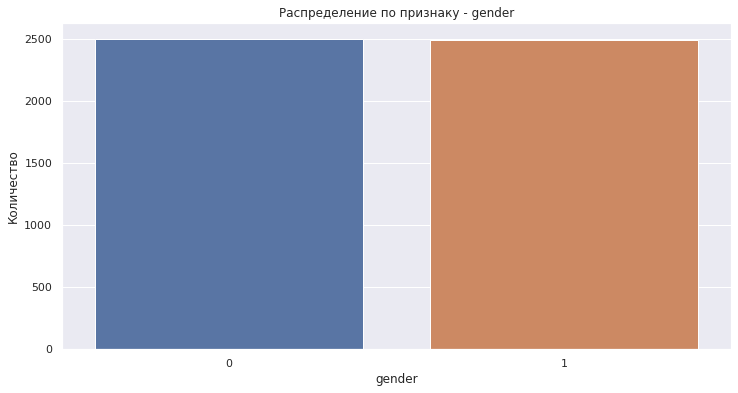

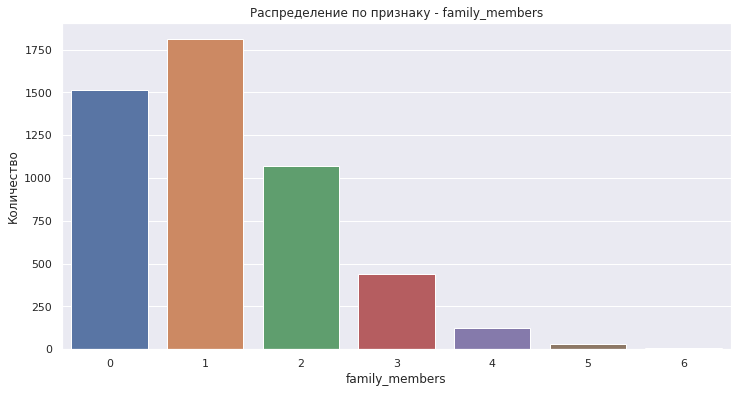

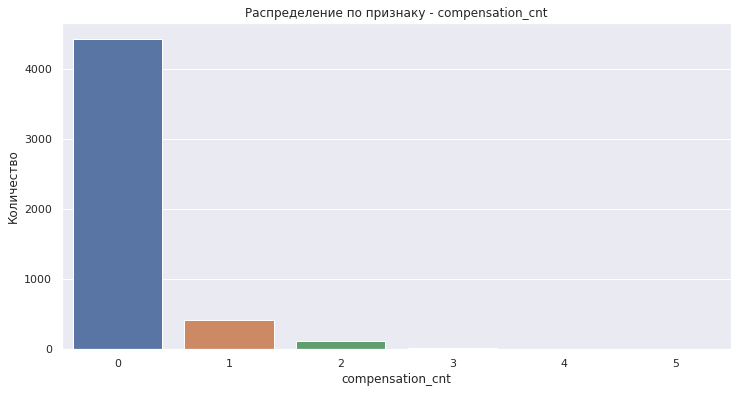

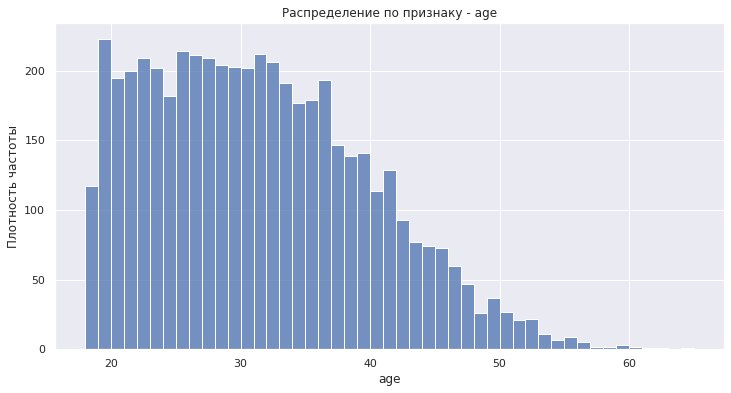

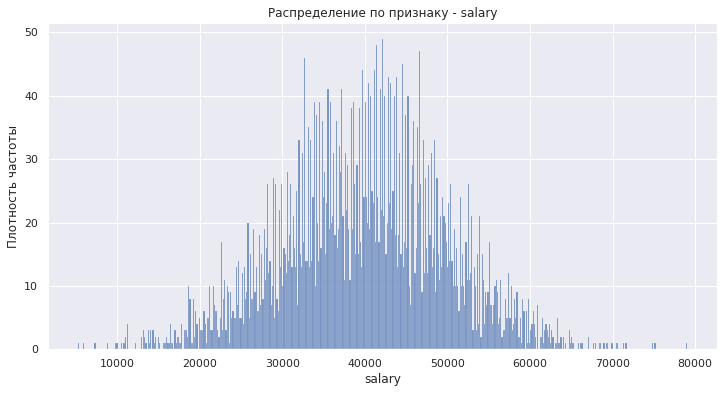

In [7]:
# напишем функции для отрисовки графиков распределения по каждому признаку
def countplot(data, column):
    sns.set()
    _, ax = plt.subplots(figsize=(12, 6))
    sns.countplot(data=data, x=column)
    ax.set_title(f'Распределение по признаку - {column}')
    plt.ylabel('Количество');
    

def histplot(data, column):
    sns.set()
    _, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(data[column], bins=data[column].nunique()+1)
    ax.set_title(f'Распределение по признаку - {column}')
    plt.ylabel('Плотность частоты'); 
    

# вызовем функции отрисовки графиков для двух групп признаков
for col in ['gender', 'family_members', 'compensation_cnt']:
    countplot(df, col)
for col in ['age', 'salary']:
    histplot(df, col)

Из графиков распределения можно сделать следующие выводы:
- распределение по признаку `'gender'` является `равномерным` (мужчины и женщины представлены в данных в одинаковом количестве);
- клиенты, проживающие (имеющие) с **1** (одним) членом семьи представляют наибольшую группу среди остальных, на втором месте распологается группа клиентов, не имеющих ни одного челна семьи, на третьем - **2** (двух) членов семьи;
- среди представленных в данных клиентов большая часть `ни разу не заправшивала страховых выплат`;
- признак `'age'` характеризуется близким к распределению Пуассона c плавным спадом вправо. Основная часть клиентов представлена в возрасте от 18 до 42 лет;
- признак `'salary'` имеет практически `нормальное распределение` со `средним значением (и медианой)` порядка `40000 у.е.` `Стандартное отклонение` составляет `9900 у.е`.

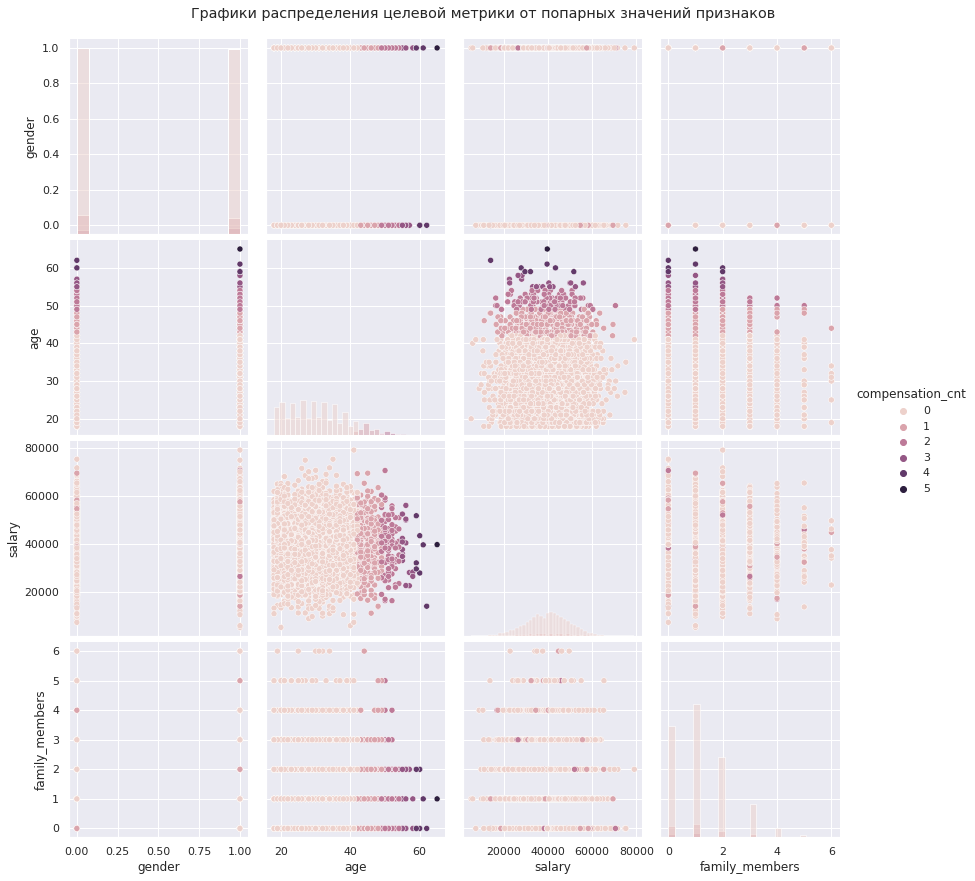

In [8]:
# построим попарные графики распределения в разрезе целевого признака 'compensation_cnt'
sns.pairplot(df, hue='compensation_cnt', height=3.0, diag_kind='hist')
plt.suptitle('Графики распределения целевой метрики от попарных значений признаков', y=1.02);

Из попарного графика распределения значений признаков в разрезе целевого признака `'Страховые выплаты'` можно выделить следующие особенности:
- запросы на страховые выплаты чаще встречаются у клиентов **старше 40 лет** и вероятность запроса страховой выплаты клиентом так же увеличивается с повышением возраста. Можно сказать что пизнак `compensation_cnt` хорошо и **положительно коррелирует** с признаком `'age'`, который в большей степени окажет влияние на предсказание линейной модели;
- наибольшее количество запросов на страховые выплаты (от **3 до 5**) у клиентов, которые **старше 50 лет** и имеют **не более 2-х** членов семьи.

Далее будет построена тепловая карта корреляции числовых признаков, кроме бинарного признака `'gender'`. 

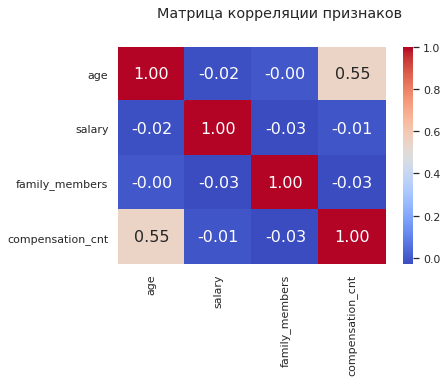

In [9]:
sns.heatmap(df.drop('gender', axis=1).corr(method='spearman'), annot=True, fmt='.2f', annot_kws={"fontsize":16}, cmap= 'coolwarm')
plt.suptitle('Матрица корреляции признаков', y=1.02);

Как было отмечено ранее между целевым признаком `['compensation_cnt']` ('Страховые выплаты') и `['age']` ('Возраст клиента') наблюдается **выраженная прямая линейная связь**.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — обратимая матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Если признаки исходных данных умножить на обратимую матрицу, то качество линейной регрессии **не изменится**.


**Обоснование:** Для преобразования данных (назовем это преобразование - шифрованием) матрицу значений всех признаков можно умножить на любую обратимую матрицу и получить то же качество линейной модели, которое мы бы получили на нешифрованных данных.

Пусть матрица $X_1$ будет результатом умножения исходной матрицы признаков $X$ и любой обратимой квадратной матрицы $P$, размерность которой должна совпадать с размерностью исходной матрицы по количеству столбцов (признаков).

$$
X_1 = XP
$$

Таким образом мы получим другой вектор весов $w1$. Подставим в формулу обучения новую матрицу $X1$ и попробуем её преобразовать согласно математических свойств и правил матричного и векторного умножения:

$$
w_1 = (X_1^T X_1)^{-1} X_1^T y = ((X P)^T (X P))^{-1} (X P)^T y = (P^T (X^T X) P)^{-1} P^T X^T y = 
$$

$$
=  P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y = P^{-1} (X^T X)^{-1} E X^T y = P^{-1} (X^T X)^{-1} X^T y 
$$

В полученную формулу вместо $(X^T X)^{-1} X^T y$ подставим $w$. Получим:

$$
=  P^{-1} w
$$

Теперь подставим полученное значение для $w_1$ в формулу для предсказания вектора целевого признака $a_1$:

$$
a_1 = X_1 w_1 = X P P^{-1} w = X E w = X w = a  
$$

Таким образом доказано, что умножение исходной матрицы признаков на любую обратимую матрицу не приведет к изменению предсказательной способности линейной модели, так как в итоге новые предсказания после преобразования - $a_1$ (вектор предсказаний целевого признака) будут равны предсказаниям модели, обученной на исходных данных - $a$ (тому же вектору целевого признака).

## Алгоритм преобразования

Для того, чтобы надежно защитить данные необходимо их не просто преобразовать (зашифровать) любой обратимой матрицей, но и обеспечить надежную передачу так называемого ключа, с помощью которого сотрудник компании мог бы дешифровать такую преобразованную матрицу в исходную для проведения например аналитики. 

Так как создание любой матрицы можно задать с помощью генератора псевдослучайных чисел (`random_seed`) предлагается на стороне сервера, где хранятся и шифруются данные выбрать определенный `random_seed` с помощью которого будет создана `псевдослучайная` обратимая матрица для преобразования исходных данных. 

Далее сервер шифрует само значение `random_seed` и передает вместе с зашифрованными данными на компьютер сотрудника. Так же сервер должен передать ключ для дешифровки `random_seed`, после чего сотрудник может преобразовать полученную зашифрованную матрицу данных путем умножения её на обратную `псевдослучайную` матрицу, которую он может создать, зная нужный `random_seed`. Для шифровки и передачи ключей предлагается использовать **алгоритм Диффи-Хеллмана**.

**Алгоритм**
1. С помощью определенного `random_seed` создать обратимую матрицу;
2. Зашифровать `random_seed` с помощью алгоритма Диффи-Хеллмана;
3. Зашифровать исходную матрицу данных с помощью созданной обратимой матрицы на шаге 1;
4. Далее сервер передает все зашифрованные данные клиенту, в том числе публичные ключи для дешифровки значения `random_seed`;
5. 
    a) Клиент может использовать полученную зашифрованную матрицу и обучить с помощью неё линейную модель и получить те же предсказания, которые можно было бы получить используя исходные данные; 

    б) С помощью переданных данных от сервера востановить значение `random_seed` и с помощью вновь созданой обратимой матрицы преобразовать данные в исходный вид для проведения какой-либо аналитики или отчетности.

Так как в рамках текущего ноутбука невозможно смоделировать передачу данных от сервера предлагается создать класс `DHEProtocol`, с помощью которого в свою очередь будут созданы объекты `my_server` и `client`. Данные объекты будут использованы для имитации шифрования и дешифрования значения `random_seed`.

In [10]:
# создадим класс для реализации алгоритма шифрования Диффи-Хелмана
class DHEProtocol():
    
    # при создании объекта будут инициализированы атрибуты ключей
    def __init__(self, public_key1, public_key2, private_key):
        self.public_key1 = public_key1
        self.public_key2 = public_key2
        self.private_key = private_key
        self.full_key = None
    
    # создаем метод объекта для генерации чатичного ключа
    def generate_partial_key(self):
        partial_key = self.public_key1**self.private_key
        partial_key = partial_key%self.public_key2
        return partial_key
    
    # создаем метод объекта для генерации полного ключа
    def generate_full_key(self, partial_key):
        full_key = partial_key**self.private_key
        full_key = full_key%self.public_key2
        self.full_key = full_key
        return full_key

    # создаем метод объекта для шифрования random_seed
    def encrypt_message(self, message):
        encrypted_message = ""
        key = self.full_key
        return message + key
    
    # создаем метод объекта для дешифрования random_seed
    def decrypt_message(self, encrypted_message):
        decrypted_message = ""
        key = self.full_key
        return encrypted_message - key

In [11]:
# задаем random_seed для генерации шифрующей матрицы
simple_mul_kye = 6007 * 797
RANDOM = simple_mul_kye

# создаем публичные и приватные ключи
server_public = 162535
server_private = 988464
client_public = 877264
client_private = 328763

# создаем объекты сервер и клиент
my_server = DHEProtocol(server_public, client_public, server_private)
client = DHEProtocol(server_public, client_public, client_private)

# генерируем частичные ключи
server_partial = my_server.generate_partial_key()
client_partial = client.generate_partial_key()

# генерируем полные ключи
server_full = my_server.generate_full_key(client_partial)
client_full = client.generate_full_key(server_partial)

# создаем зашифрованное сообщение, содержащее значение random_seed
# и проверим его значение
crypt_key = my_server.encrypt_message(RANDOM)
print(crypt_key)

5337420


In [12]:
# напишем функцию создающую матрицу для дальнейшего преобразования
# (шифрования) данных. Перед возвращением матрица обязательно
# проверяется на обратимость
def get_protect_feat_matrix(RS, size=1):
    
    # для отладки работы функции создана вырожденная матрица a
    # a = np.array([[1, 0, 2],
    #               [3, -1, 0],
    #               [4, -1, 2]])
    
    # задаем random_seed
    np.random.seed(RS) 
    # создадим матрицу нужного размера
    new_matrix = np.random.randn(size, size)
    # инвертируем полученную матрицу
    # проверим матрицу на обратимость
    # если матрица имеет обратную возвращаем её, если нет то возвращаем сообщение об ошибке
    try:
        new_matrix_inv = np.linalg.inv(new_matrix)
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print('Матрица не имеет обратной! Задайте другие параметры для генерации!')
    else:
        return new_matrix

## Проверка алгоритма

Так как результатом данного проекта является сравнение метрик (примем две метрики: `R2` и `MSE`) двух линейных моделей, обученных на обычных и зашифрованных данных, то использование `pipeline` с преобразованием категориальных признаков будет неприменимо, так как после шифрования обучающих признаков их значения примут другие значения в широком диапазоне чисел. В таком случае будет разумнее оставить только масштабирование признаков с помощью `StandardScaler`.

### Подготовка и разбивка данных для обчуения моделей

In [13]:
# создадим список числовых признаков
num_cols = ['age', 'salary', 'family_members', 'gender']

# разделим данные на признаки и таргет 
X = df.drop('compensation_cnt', axis=1).copy()
y = df['compensation_cnt'].copy()

# согласно разработанного алгоритма шифрования получим зашифрованные данные
# для начала дешифруем random_seed 
rand_s = client.decrypt_message(crypt_key)
# затем создадим обратимую матрицу используя полученный и дешифрованный random_seed
X_crypt = X @ get_protect_feat_matrix(rand_s, size=X.shape[1])
X_crypt.columns = X.columns
X_crypt.head(10)

,gender,age,salary,family_members
0,-31658.535541,30315.709687,-52702.025413,-1919.842907
1,-24283.925162,23211.969418,-40369.670349,-1470.658395
2,-13427.030455,12823.715543,-22307.293006,-813.248806
3,-26590.608736,25500.648844,-44315.703892,-1613.325696
4,-16671.145568,15946.069609,-27728.635995,-1010.540336
5,-26187.220836,25052.201357,-43560.753461,-1585.591959
6,-25351.692691,24260.415142,-42180.908753,-1535.277399
7,-24624.085845,23602.557257,-41020.384997,-1490.803000
8,-31712.380538,30381.582357,-52810.774395,-1923.784066
9,-32977.862298,31609.215242,-54938.599865,-2001.326543


Следуюющий этап - подготовка трансформеров для обучения модели с использованием Pipeline.

In [14]:
# препроцессинг (масштабирование) числовых признаков
scale_transformer = StandardScaler()

# общий препроцессинг числовых и категориальных признаков:
preprocessing = ColumnTransformer(
    transformers=[
        ('num', scale_transformer, num_cols)
    ])

Раздедим данные на обучающую и тестовую выборки в соотношении 4:1 (80% и 20%).

In [15]:
# разбивка незашифрованных данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RAND_ST) 
# разбивка зашифрованных данных
X_crypt_train, X_crypt_test = train_test_split(X_crypt, test_size=.2, random_state=RAND_ST)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_crypt_train.shape, X_crypt_test.shape)

(4000, 4) (1000, 4) (4000,) (1000,)
(4000, 4) (1000, 4)


### Иследование качества модели на нешифрованных данных

In [16]:
# обучим модель на нешифрованных данных
pipe_lr = Pipeline(steps=[('preprocessor', preprocessing),
                          ('LRM', LinearRegression())])
pipe_lr.fit(X_train, y_train)
# получим предсказания линейной модели на обучающей и тестовой выборке
train_predict = pipe_lr.predict(X_train)
test_predict = pipe_lr.predict(X_test)

# выведем метрику R2 на обучащей и тествоой выборке
print(f'Значение метрики "R2" на обучающей выборке:{pipe_lr.score(X_train, y_train):.5f}')
print(f'Значение метрики "MSE" на обучающей выборке:{mean_squared_error(y_train, train_predict):.5f}')
print(f'Значение метрики "R2" на тестовой выборке:{pipe_lr.score(X_test, y_test):.5f}')
print(f'Значение метрики "MSE" на тестовой выборке:{mean_squared_error(y_test, test_predict):.5f}')

Значение метрики "R2" на обучающей выборке:0.42094
Значение метрики "MSE" на обучающей выборке:0.11768
Значение метрики "R2" на тестовой выборке:0.43445
Значение метрики "MSE" на тестовой выборке:0.14654


### Иследование качества модели на шифрованных данных

In [17]:
# обучим модель на нешифрованных данных
crypt_pipe_lr = Pipeline(steps=[('preprocessor', preprocessing),
                          ('LRM_CR', LinearRegression())])
crypt_pipe_lr.fit(X_crypt_train, y_train)
# получим предсказания линейной модели на обучающей и тестовой выборке
cr_train_predict = crypt_pipe_lr.predict(X_crypt_train)
cr_test_predict = crypt_pipe_lr.predict(X_crypt_test)

# выведем метрику R2 на обучащей и тествоой выборке
print(f'Значение метрики "R2" на обучающей выборке:{crypt_pipe_lr.score(X_crypt_train, y_train):.5f}')
print(f'Значение метрики "MSE" на обучающей выборке:{mean_squared_error(y_train, cr_train_predict):.5f}')
print(f'Значение метрики "R2" на тестовой выборке:{crypt_pipe_lr.score(X_crypt_test, y_test):.5f}')
print(f'Значение метрики "MSE" на тестовой выборке:{mean_squared_error(y_test, cr_test_predict):.5f}')
# print(y_test.values[:20])
# print(np.round(cr_test_predict).astype(int)[:20])

Значение метрики "R2" на обучающей выборке:0.42094
Значение метрики "MSE" на обучающей выборке:0.11768
Значение метрики "R2" на тестовой выборке:0.43445
Значение метрики "MSE" на тестовой выборке:0.14654


Как и было доказано на шаге 2: после преобразования исходных данных с помощью обратимой матрицы качество линейной модели **не изменяется**. Это можно увидить сравнив метрики качества `R2` и `MSE`. В обоих случаях они равны. 

## Улучшение предсказательной способности модели регрессии

В связи с низкой предсказательной способностью стандартной линейной модели (коэффициент детерминации $R^2$ на обучающей и тестовой выборке составлет всего лишь **0.42** и **0.43** соответственно, что скорее всего связано с нелинейной зависимостью целевого признака) предлагается изменить базисную функцию линейной регресии на полиномиальную. 

В рамках текущего проекта так же будет проведено сравнение предсказательной способности модели регрессии с полиномиальной функцией на `шифрованных` и `нешифрованных данных`.

In [39]:
# обучим модель на нешифрованных данных
pipe_lr_polinom = Pipeline(steps=[('preprocessor', preprocessing),
                          ('polinom', PolynomialFeatures(4)),
                          ('LRM_POLINOM', LinearRegression())])
pipe_lr_polinom.fit(X_train, y_train)
# получим предсказания линейной модели на обучающей и тестовой выборке
pol_train_predict = pipe_lr_polinom.predict(X_train)
pol_test_predict = pipe_lr_polinom.predict(X_test)

# выведем метрику R2 на обучащей и тествоой выборке
print(f'Значение метрики "R2" на обучающей выборке:{pipe_lr_polinom.score(X_train, y_train):.5f}')
print(f'Значение метрики "MSE" на обучающей выборке:{mean_squared_error(y_train, pol_train_predict):.5f}')
print(f'Значение метрики "R2" на тестовой выборке:{pipe_lr_polinom.score(X_test, y_test):.5f}')
print(f'Значение метрики "MSE" на тестовой выборке:{mean_squared_error(y_test, pol_test_predict):.5f}')
# print(y_test.values[:20])
# print(np.round(pol_test_predict).astype(int)[:20])

Значение метрики "R2" на обучающей выборке:0.90342
Значение метрики "MSE" на обучающей выборке:0.01963
Значение метрики "R2" на тестовой выборке:0.91178
Значение метрики "MSE" на тестовой выборке:0.02286


In [38]:
# обучим модель на шифрованных данных
crypt_pipe_lr_polinom = Pipeline(steps=[('preprocessor', preprocessing),
                          ('polinom', PolynomialFeatures(4)),
                          ('LRM_CR_POLINOM', LinearRegression())])
crypt_pipe_lr_polinom.fit(X_crypt_train, y_train)
# получим предсказания линейной модели на обучающей и тестовой выборке
cr_pol_train_predict = crypt_pipe_lr_polinom.predict(X_crypt_train)
cr_pol_test_predict = crypt_pipe_lr_polinom.predict(X_crypt_test)

# выведем метрику R2 на обучащей и тествоой выборке
print(f'Значение метрики "R2" на обучающей выборке:{crypt_pipe_lr_polinom.score(X_crypt_train, y_train):.5f}')
print(f'Значение метрики "MSE" на обучающей выборке:{mean_squared_error(y_train, cr_pol_train_predict):.5f}')
print(f'Значение метрики "R2" на тестовой выборке:{crypt_pipe_lr_polinom.score(X_crypt_test, y_test):.5f}')
print(f'Значение метрики "MSE" на тестовой выборке:{mean_squared_error(y_test, cr_pol_test_predict):.5f}')
# print(y_test.values[:20])
# print(np.round(cr_pol_test_predict).astype(int)[:20])

Значение метрики "R2" на обучающей выборке:0.90349
Значение метрики "MSE" на обучающей выборке:0.01961
Значение метрики "R2" на тестовой выборке:0.91247
Значение метрики "MSE" на тестовой выборке:0.02268


{'degree': 6,
 'interaction_only': False,
 'include_bias': True,
 'order': 'C',
 'n_features_in_': 4,
 'n_input_features_': 4,
 'n_output_features_': 210}

## Выводы

**Основная задача проекта**: для страховой компании "Хоть потоп" необходимо разработать и внедрить алгоритм защиты персональных данных, позволяющий обучить линейную модель на таких данных для предсказания целевой метрики `количество страховых выплат` без потери качества предсказания.

По итогу работ было выполнено следующее:

1. Данные загружены и исследованы (данные проверены на наличие пропусков, аномальных значений, построены и изучены графики распределения значений признаков, а так же тепловая карта корреляции Спирмена). Обнаружена сильная прямая линейная связь между целевым признаком (`'страховые выплаты'`) и возрастом клиентов (`'возраст'`). 
2. Разработан алгоритм преобразования данных. Из особенностей алгоритма преобразования стоит выделить основные моменты:
- данные преобразуются с помощью случайной обратимой матрицы, созданной с помощью определенного значения генератора псевдослучайных чисел (параметра `random_seed`);
- для дополнительной защиты и безопасной передачи `random_seed`, данный параметр был зашифрован алгоритмом Диффи-Хелмана. С помощью дешифрованного значения сотрудник компании имеет возможность восстановить исходные данные для их анализа или составления отчетности.
3. Математически и практически на примере доказано, что качество линейной регрессии не меняется с использованием разработнного алгоритма шифрования данных. Метрики качества модели `'R2'` и `'MSE'` после преобразования данных **не изменились**.